In [1]:
# the pde module is packaged now but is very limited in the problems they can solve
from neurodiffeq import diff
from neurodiffeq.pde import DirichletBVP2D, ExampleGenerator2D, Monitor2D, solve2D, make_animation
from neurodiffeq.networks import FCNN

import numpy as np
import torch
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d  import Axes3D

In [2]:
class IBVP:
    
    def __init__(self, x_min, x_min_val, x_max, x_max_val, t_min, t_min_val, t_max):
        self.x_min, self.x_min_val = x_min, x_min_val
        self.x_max, self.x_max_val = x_max, x_max_val
        self.t_min, self.t_min_val = t_min, t_min_val
        self.t_max = t_max
    
    def enforce(self, u, x, t):
        x_tilde = (x-self.x_min) / (self.x_max-self.x_min)
        t_tilde = (t-self.t_min) / (self.t_max-self.t_min)
        Axt = (1-x_tilde)*self.x_min_val(t) + x_tilde*self.x_max_val(t) + \
              (1-t_tilde)*( self.t_min_val(x) - (1-x_tilde)*self.t_min_val(self.x_min * torch.ones_like(x_tilde))
                                              -    x_tilde *self.t_min_val(self.x_max * torch.ones_like(x_tilde))
                          ) 
        return Axt + x_tilde*(1-x_tilde)*t_tilde*u

<IPython.core.display.Javascript object>


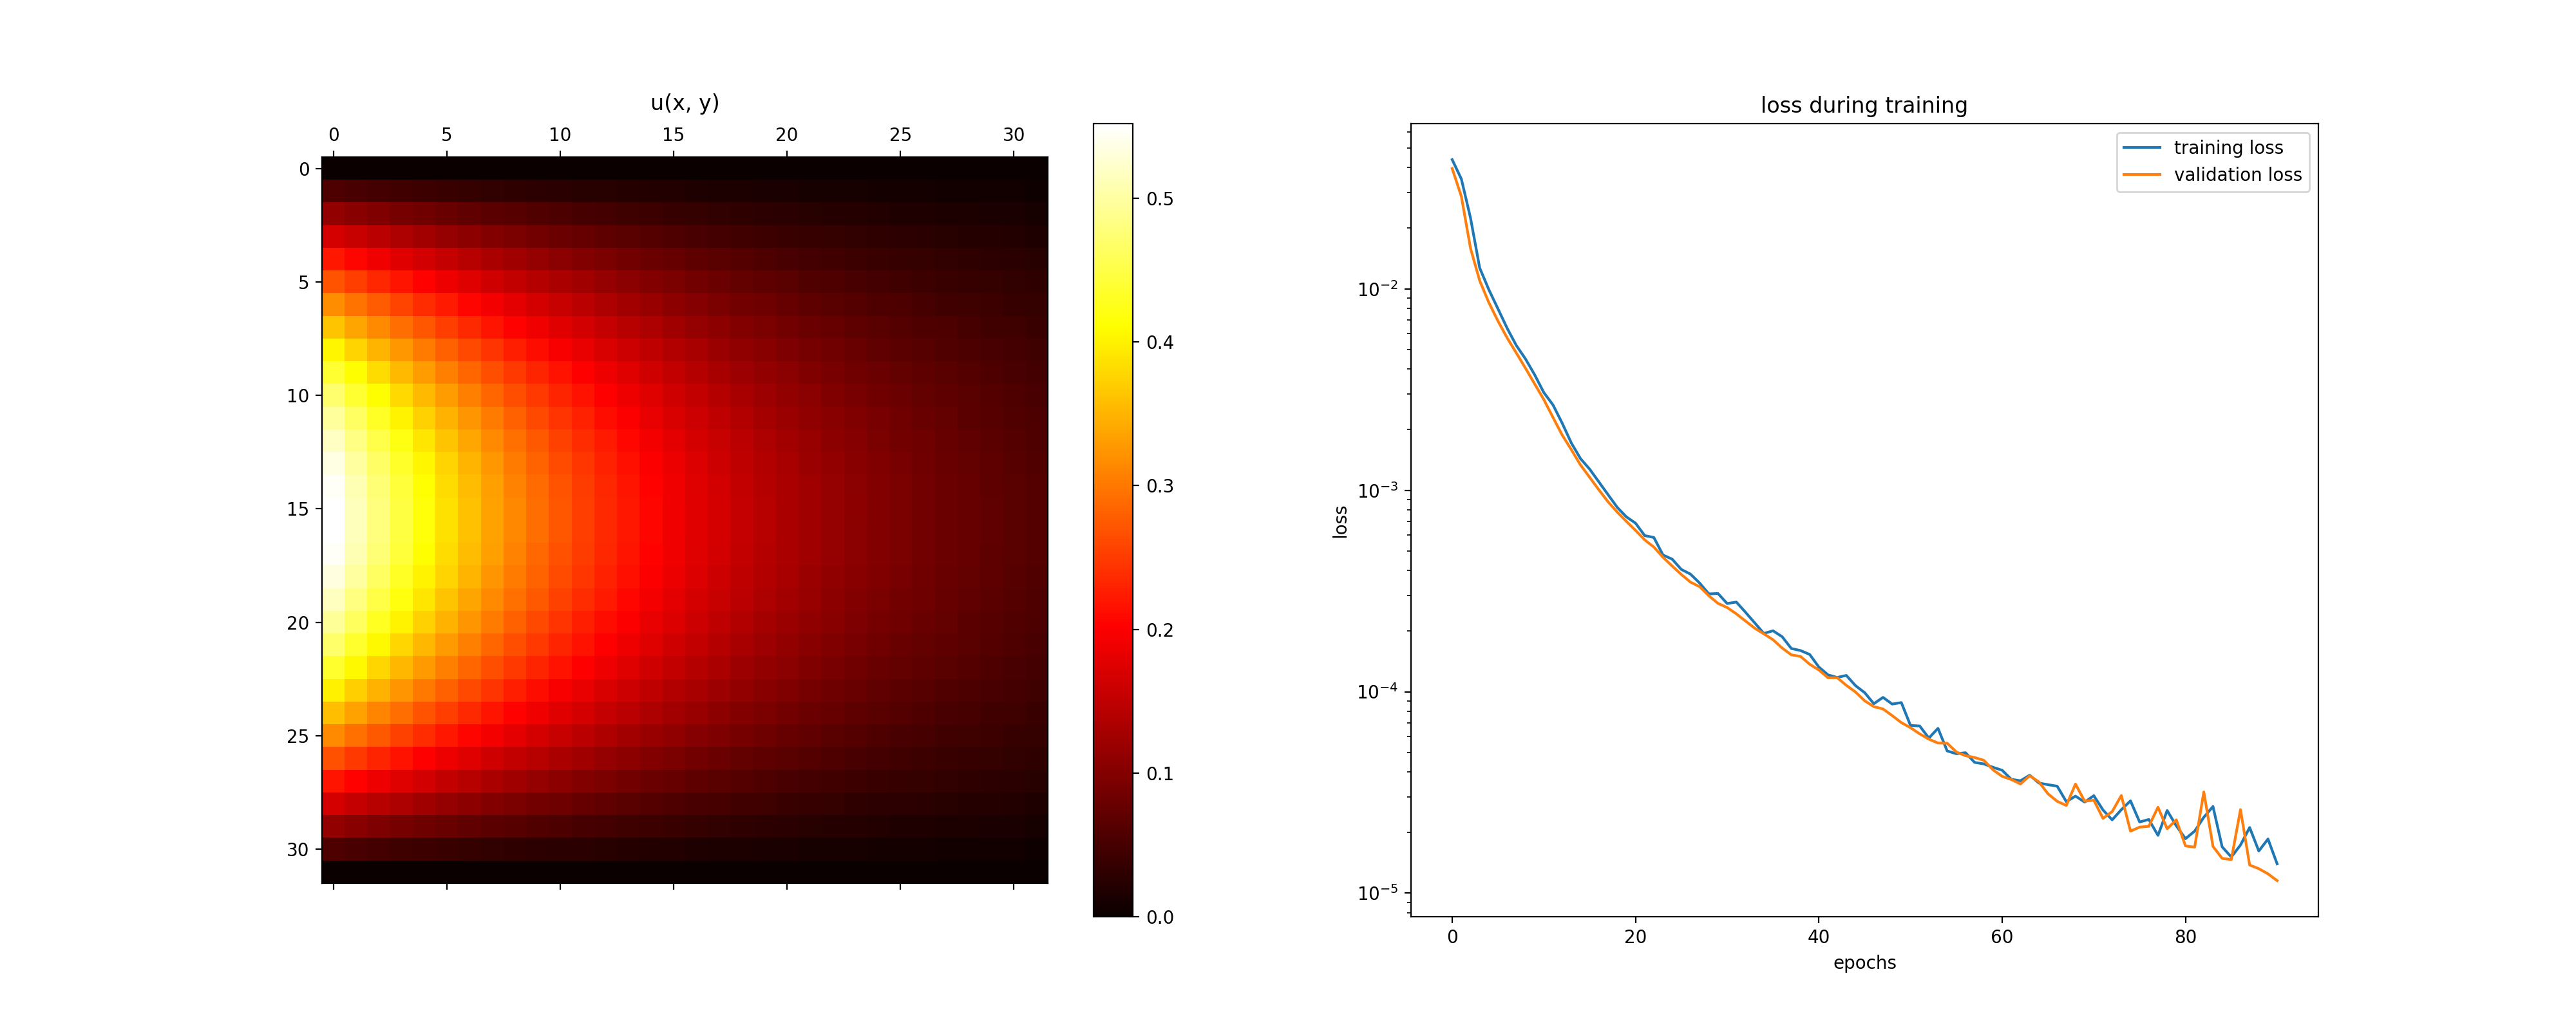

In [3]:
%matplotlib notebook

k = 0.5
L, T = 3, 4
Nx, Nt = 32,512

heat = lambda u, x, t: diff(u, t) - k * diff(u, x, order=2)

BC = IBVP(
    x_min=0, x_min_val=lambda t: 0, 
    x_max=L, x_max_val=lambda t: 0,
    t_min=-L, t_min_val=lambda x: -(x-L)**2+L**2, 
    t_max=T
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=2)

solution_neural_net, _ = solve2D(
    pde=heat, condition=BC, xy_min=[0, 0], xy_max=[L, T],
    net=net, max_epochs=100, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [L, T], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[L, T])
)

<IPython.core.display.Javascript object>


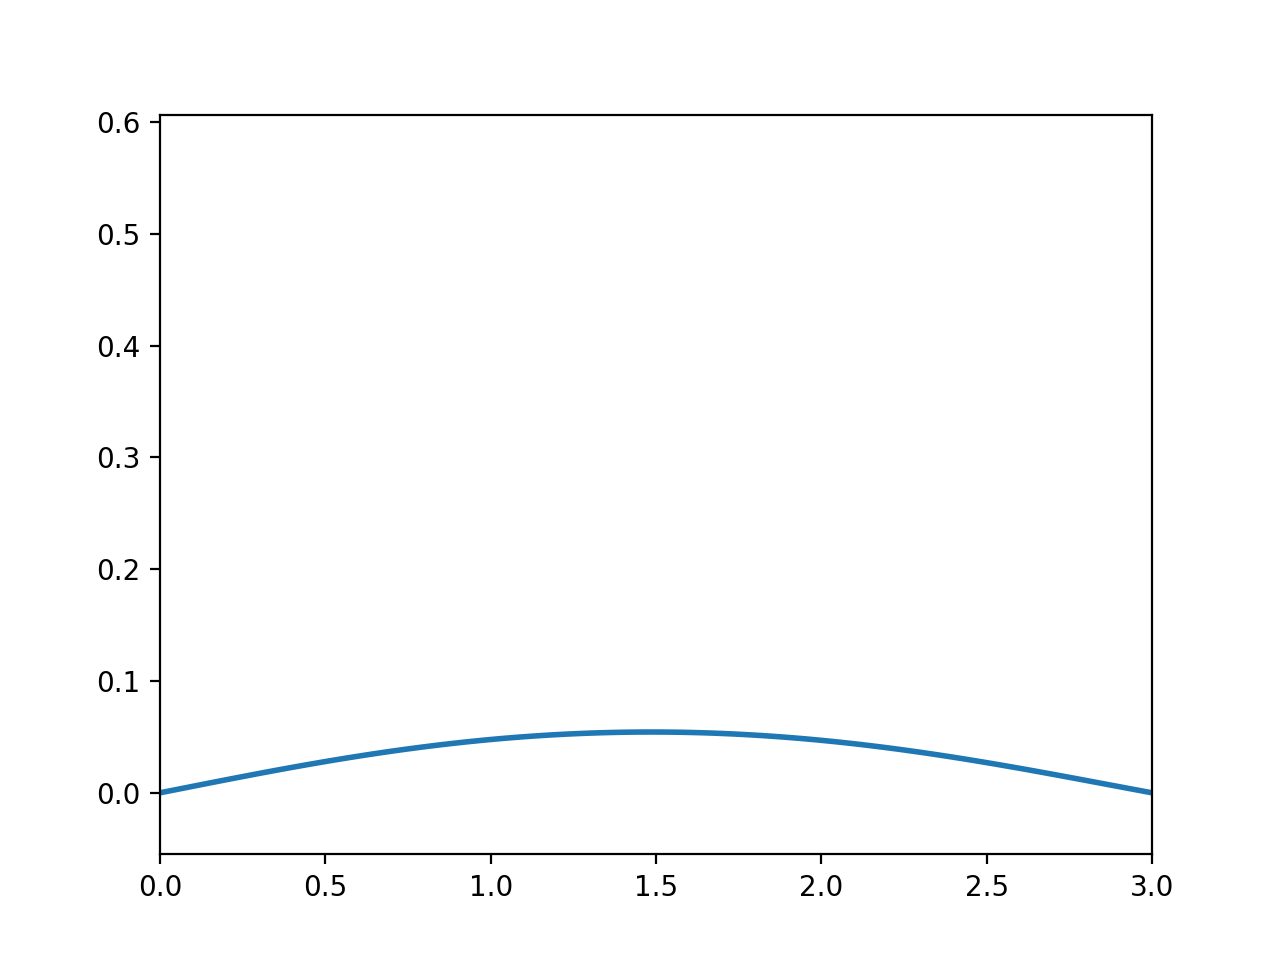

In [4]:
xs, ts = np.linspace(0, L, 100), np.linspace(0, T, 200)
ani = make_animation(solution_neural_net, xs, ts)

In [5]:
class IVP:
    
    def __init__(self, t_min, t_min_val):
        self.t_min, self.t_min_val = t_min, t_min_val
    
    def enforce(self, u, x, t):
        Axt = self.t_min_val(x)
        return Axt + (1-torch.exp(-t+self.t_min))*u

<IPython.core.display.Javascript object>


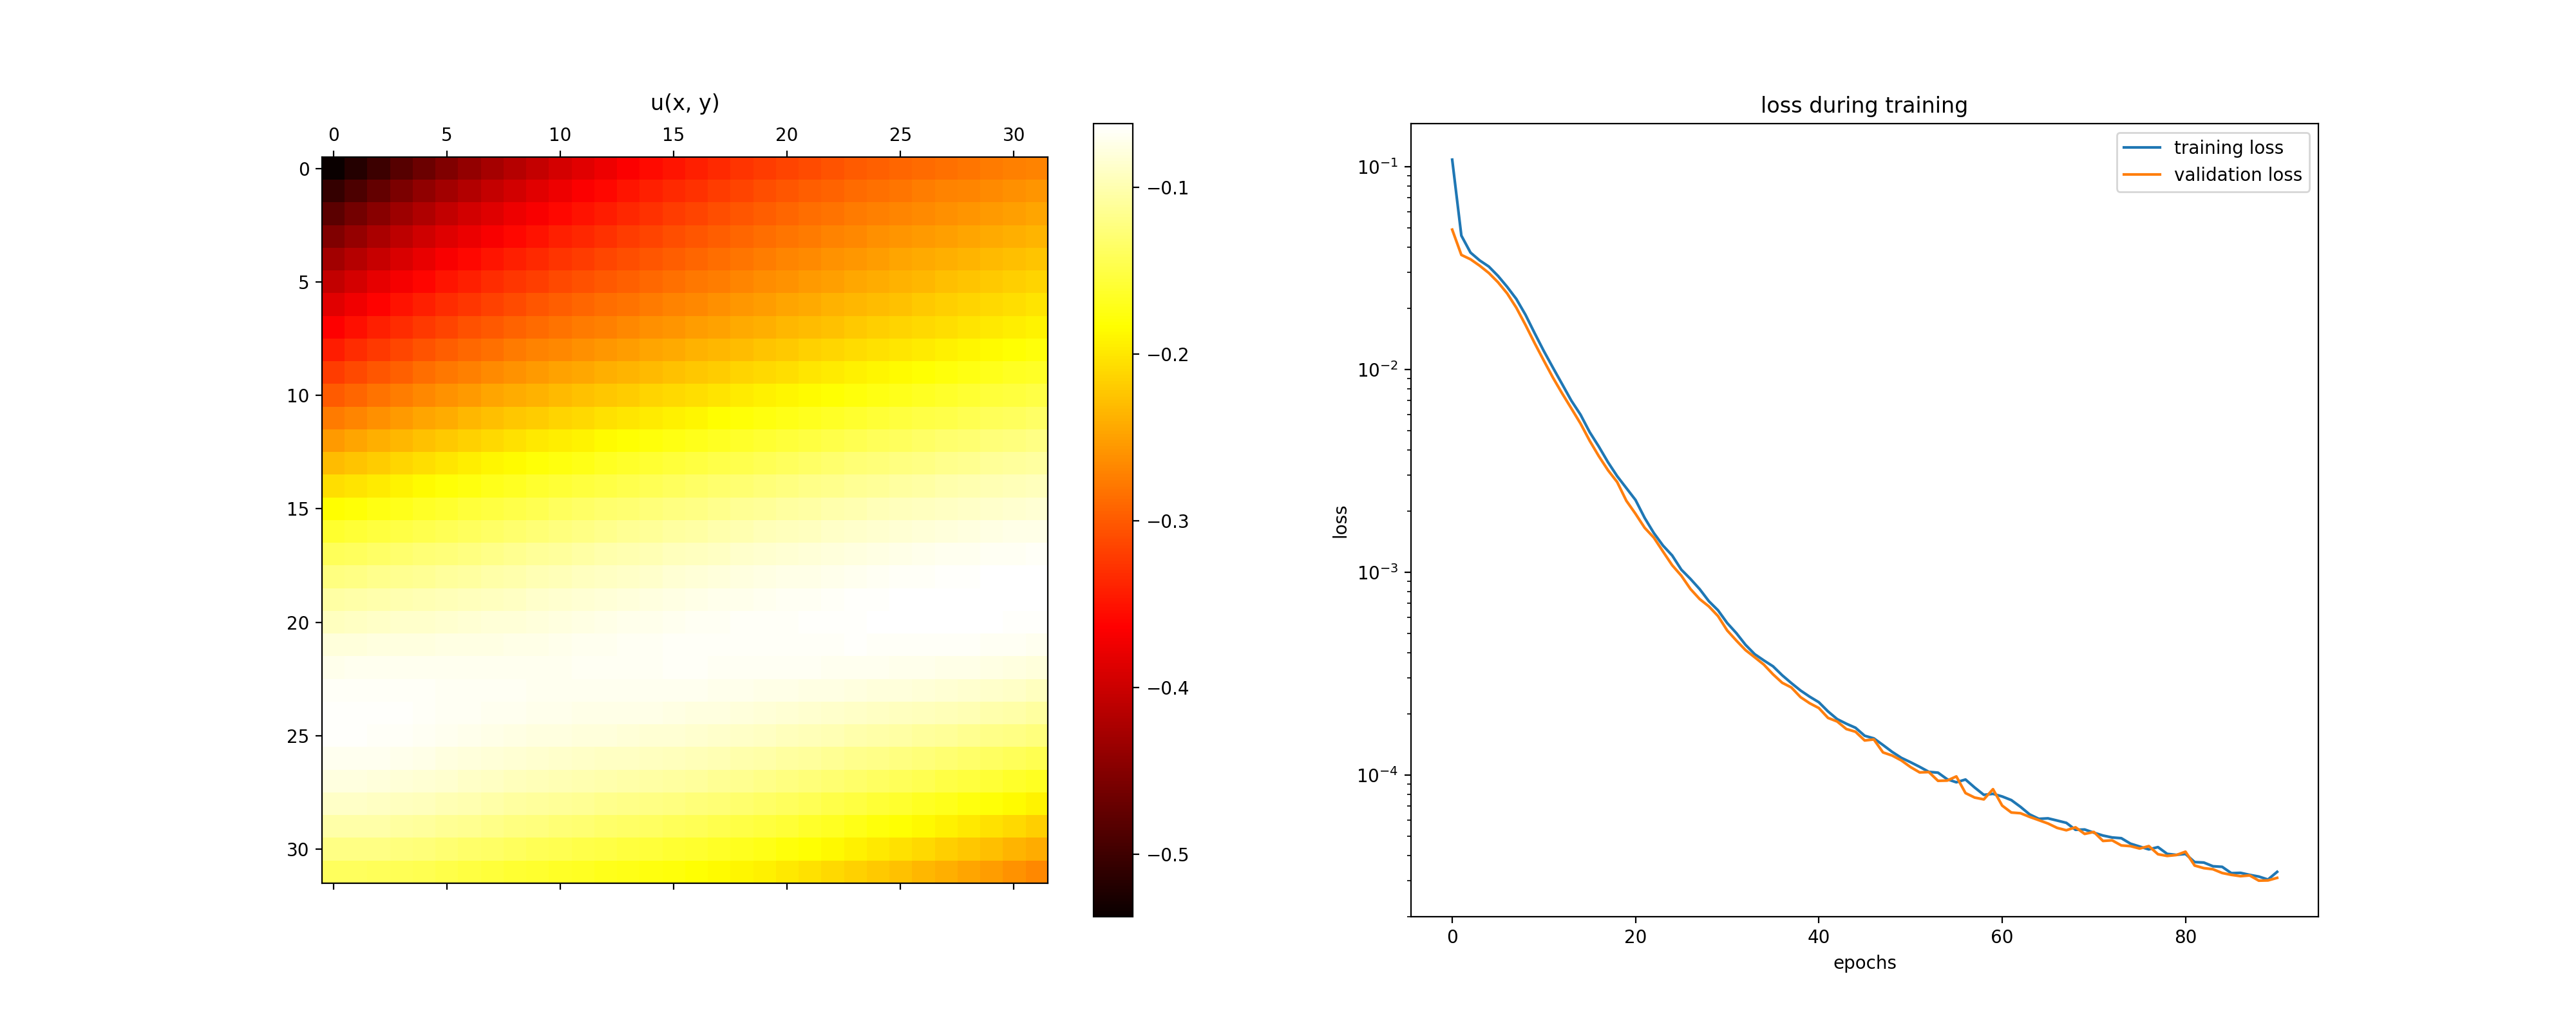

In [6]:
%matplotlib notebook

L, T = 3, 4
v = -1
invisid_burgers = lambda u, x, t: diff(u, t) + u * diff(u, x)

IC = IVP(
    t_min=-L, t_min_val=lambda x: torch.sin(np.pi * x/L)
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=2)

solution_neural_net, _ = solve2D(
    pde=invisid_burgers, condition=IC, xy_min=[0, 0], xy_max=[L, T],
    net=net, max_epochs=100, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [L, T], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[L, T])
)

<IPython.core.display.Javascript object>


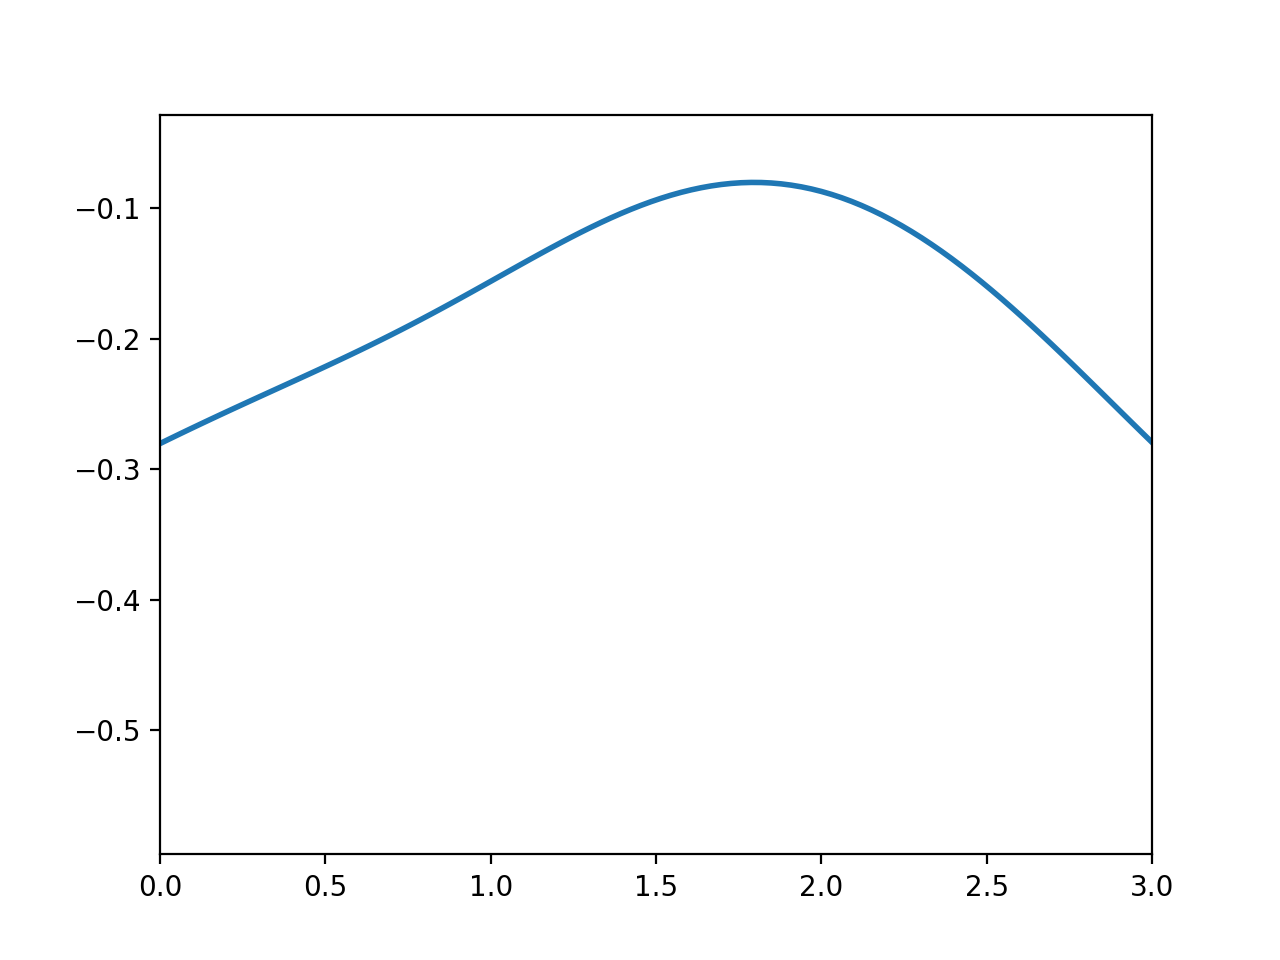

In [7]:
xs, ts = np.linspace(0, L, 100), np.linspace(0, T, 200)
ani = make_animation(solution_neural_net, xs, ts)
# initial condition does not satisfy, why?